<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/20_Pro_RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Сделайте оценку того, как блоки слов в словаре влияют на точность классификации (на любой базе, например, распознавание писателей). Для этого выполните следующее:

Сформируйте словарь.

Используйте первые 50000 слов из словаря, который формируется токенайзером (50000 самых часто-используемых слов). Обучите нейросеть на этой базе.

Разбейте все слова на блоки по 100 слов последовательно.

Проверьте точность модели с помощью model.evaluate() на немного измененной проверочной выборке. Используя цикл, поочередно отключайте блоки по одному.

Сделайте так, чтобы эти слова не использовались при предсказании, например, их индексы всегда приравнивались к 0.

Оцените, как меняется точность классификации на проверочной выборке.

Сделайте выводы, какие блоки слов влияют в плюс, а какие в минус.

Соберите итоговую подборку слов, в которую войдут только те блоки по 100 слов, которые улучшили точность (исключение которых давало падение точности).

Обучите сеть только на этих блоках слов.

Оцените изменение точности в сравнении с обучением на полном словаре (первые 50000 слов).

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
# Чтение файла + запись в одну строку
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text

In [ ]:



# Функции для формирования выборки по отрезкам текста с заданным шагом
# Разделение на короткие векторы
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  #Идем по всей длине вектора индексов и откусываем векторы длиной xLen , смещаемся на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

# Формирование обучающей и проверочной выборки из двух листов индексов от двух классов

def createSetsMultiClasses (wordIndexes, xLen, step):
  #Для каждого из 6 классов создаем обучающую и проверочную выборки из индексов
  nClasses = len(wordIndexes) #задали количество классов выборки
  classesXSamples = [] # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  #Создаем один общий xSamples
  xSamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range (nClasses):   # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]    # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range (len(xT)):  # и каждое его окно
      xSamples.append(xT[i])   # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса  
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):   # на каждое окно выборки 
      ySamples.append(currY)   # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples) # функция возвращает выборку и соответствующие векторы классов

# Представляем тестовую выборку в удобных для распознавания размерах
 
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
   
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
     
   
  return  xTest6Classes # функция вернёт тестовые данные: xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты

def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим средний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount




In [ ]:
# График 

def show_res():
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  # plt.plot(history.history['val_loss'], 
  #         label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  # Строим график для отображения динамики обучения и точности предсказания сети
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  # plt.plot(history.history['val_accuracy'], 
  #         label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

# Загрузка данных


In [ ]:
# Cоздание обучающей выборки
trainText = []
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))

className = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

# Создание тестовой выборки
testText = []
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))

# Обработка данных


In [ ]:
# Преобразуем данные в числовые/векторные
maxWordsCount = 50000

tokenizer = Tokenizer(num_words=maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', char_level = False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова
tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

# Создание обучающей выборки по 100 слов

In [ ]:
# Задаём базовые параметры
xLen = 100 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)


(17712, 100)
(17712, 6)
(6747, 100)
(6747, 6)


# Эксперименты

## Embedding + Dense

####**Иссл. №1**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 80)           4000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 80)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 80)           320       
_________________________________________________________________
dense (Dense)                (None, 100, 64)           5184      
_________________________________________________________________
dense_1 (Dense)              (None, 100, 32)           2080      
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

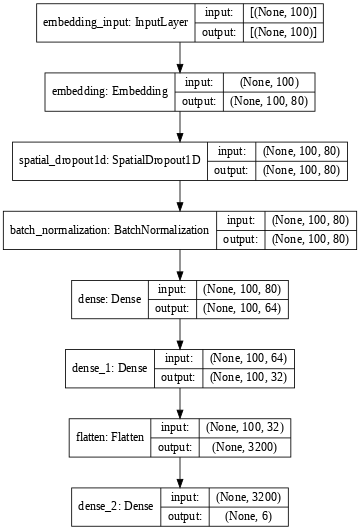

In [ ]:
# Embedding = 80
modelEmb_Dense2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEmb_Dense2.add(Embedding(maxWordsCount, 80, input_length=xLen))

modelEmb_Dense2.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEmb_Dense2.add(BatchNormalization()) # добавляем слой нормализации данных

modelEmb_Dense2.add(Dense(64, activation = 'relu')) 

modelEmb_Dense2.add(Dense(32, activation='relu')) 
modelEmb_Dense2.add(Flatten())
modelEmb_Dense2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEmb_Dense2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelEmb_Dense2.summary() # Выводим summary модели
print()
plot_model(modelEmb_Dense2, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEmb_Dense2.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512)

Epoch 1/50
35/35 [==============================] - 3s 7ms/step - loss: 1.7123 - accuracy: 0.3185
Epoch 2/50
35/35 [==============================] - 0s 7ms/step - loss: 1.2138 - accuracy: 0.5529
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.7730
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 0.3414 - accuracy: 0.9041
Epoch 5/50
35/35 [==============================] - 0s 7ms/step - loss: 0.1447 - accuracy: 0.9657
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9871
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9972
Epoch 8/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9973
Epoch 9/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 0.9984
Epoch 10/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 0.9990
Epoch 11/50
35/35 [

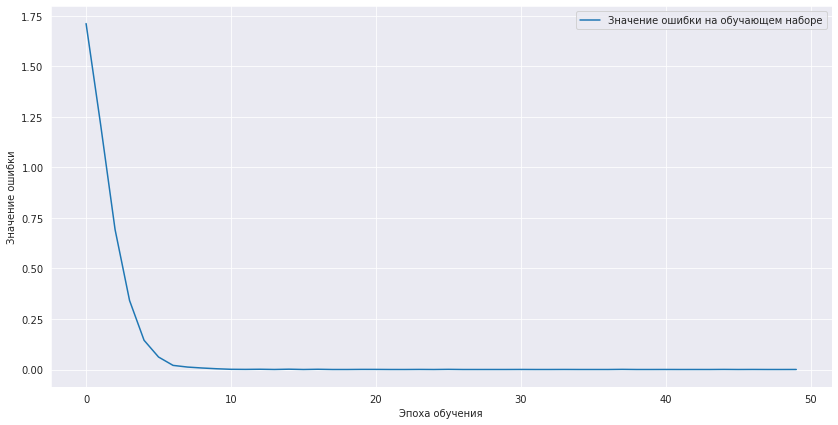

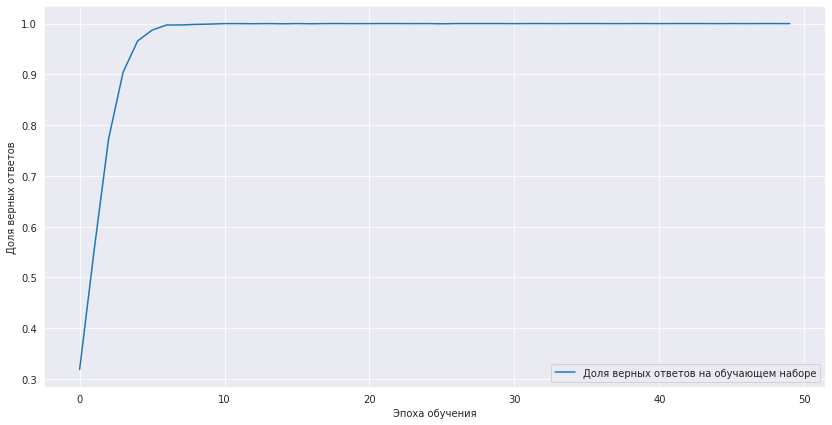

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

# Отключение по 100

In [ ]:
# Cоздание обучающей выборки
trainText = []
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))

className = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

# Создание тестовой выборки
testText = []
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))

In [ ]:
import os 
# загружаем обучающие тексты

trainText = []  # формируем обучающие тексты
testText = []   # формируем тестовые тексты

# формирование необходимо произвести следующим образом: 
# класс каждого i-ого элемента в обучающей выборке должен соответствовать 
# классу каждого i-ого элемента в тестовой выборке

for i in className:              # проходим по каждому классу
  for j in os.listdir('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/'): # проходим по каждому файлу в папке с текстами
    if i in j:                   # проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j:                       # если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/' + j)) # добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') # выводим информацию
      if 'Тестовая' in j:                        # если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/' + j))  # добавляем в тестовую выборку
        print(j, 'добавлен в тестовую выборку')  # выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample
  
# формирование обучающей и проверочной выборки
# из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):   # в диапазоне кол-ва классов (6)
    xT = classesXSamples[t]   # берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)):  # и каждое его окно
      xSamples.append(xT[i])  # добавляем в общий список выборки
    
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):  # на каждое окно выборки 
      ySamples.append(currY)  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Преобразуем данные в числовые/векторные
maxWordsCount = 50000

tokenizer = Tokenizer(num_words=maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', char_level = False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова
tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тексты в индексы

In [ ]:
[print(len(set(trainWordIndexes[i]))) for i in range(len(trainWordIndexes))]

22740
29322
26162
22589
32736
22687


[None, None, None, None, None, None]

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step) # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


In [ ]:
xTrain[0]

array([23768,     7, 27541,  1733, 23769,     3,     1, 40124,    11,
           1,  7515,     3,  3237,     1, 40125,   274,  1045,    16,
         257,  2119,     7, 27542,     1,   646,     9,  2527,     1,
           1,     3,  1631,  7853,  9575,   956,    11,    28,    55,
           1,   132,   130,     1,   123,  1444,  3238, 40126,   921,
       40127,  1153, 15417,     1,    36,   190, 40128,    64,     1,
        2625,  4808, 32459,   938,     1,  1908, 40129,  2891,     3,
       21071, 10109,     2,     1, 16930,     1,   221, 27543,     1,
          11, 15418,     1,   144,   713, 23770,     1,     1,   583,
         274, 32460,     2, 40130,  1990, 40131,  6648,    17, 40132,
       40133,   373, 14209,    76,    15,  1488,     1, 14210, 10778,
        1194,     7,     1,     1,     1, 23771, 14210,   105,     1,
        8638,  7516,    50,    63,     1, 14211,  2626,   244,   274,
        4189,    80,  2450, 11437,     4,   738,  3473,     3,  1733,
        4190,  4668,

In [ ]:
x = np.where((0 < xTrain) & (xTrain <= 100), 1, xTrain)
x[0]

array([23768,     1, 27541,  1733, 23769,     1,     1, 40124,     1,
           1,  7515,     1,  3237,     1, 40125,   274,  1045,     1,
         257,  2119,     1, 27542,     1,   646,     1,  2527,     1,
           1,     1,  1631,  7853,  9575,   956,     1,     1,     1,
           1,   132,   130,     1,   123,  1444,  3238, 40126,   921,
       40127,  1153, 15417,     1,     1,   190, 40128,     1,     1,
        2625,  4808, 32459,   938,     1,  1908, 40129,  2891,     1,
       21071, 10109,     1,     1, 16930,     1,   221, 27543,     1,
           1, 15418,     1,   144,   713, 23770,     1,     1,   583,
         274, 32460,     1, 40130,  1990, 40131,  6648,     1, 40132,
       40133,   373, 14209,     1,     1,  1488,     1, 14210, 10778,
        1194,     1,     1,     1,     1, 23771, 14210,   105,     1,
        8638,  7516,     1,     1,     1, 14211,  2626,   244,   274,
        4189,     1,  2450, 11437,     1,   738,  3473,     1,  1733,
        4190,  4668,

In [ ]:
# Отключаем первые 100 токенов, преобразуя их в 1
x = np.where((0 < xTrain) & (xTrain <= 100), 1, xTrain) 
x[0] # Пример отрезка текста с отключенным первым блоком

In [ ]:
# Создаем функцию, которая отключает блоки по индексу размером окна window
def block_off(X, i, window):
    return np.where((i*window < X) & (X <= (i+1)*window), 1, X)

# Функция создания модели
def creat_model(maxWordsCount, xLen):
    modelED = Sequential() # создаём последовательную модель нейросети

    # преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
    modelED.add(Embedding(maxWordsCount, 50, input_length=xLen))
    modelED.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
    modelED.add(Flatten())
    modelED.add(BatchNormalization())  # добавляем слой нормализации данных
    modelED.add(Dense(200, activation="relu"))  # добавляем полносвязный слой
    modelED.add(Dropout(0.2))
    modelED.add(BatchNormalization())
    modelED.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

    return modelED

In [ ]:
# Создаем модель
model = creat_model(maxWordsCount=maxWordsCount, xLen=xLen)

model.compile(optimizer=RMSprop(lr=1e-4), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
138/138 [==============================] - 4s 13ms/step - loss: 1.6623 - accuracy: 0.4268 - val_loss: 1.6992 - val_accuracy: 0.3154
Epoch 2/10
138/138 [==============================] - 2s 12ms/step - loss: 0.1776 - accuracy: 0.9589 - val_loss: 1.4778 - val_accuracy: 0.4674
Epoch 3/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0275 - accuracy: 0.9985 - val_loss: 1.2662 - val_accuracy: 0.5105
Epoch 4/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0074 - accuracy: 0.9997 - val_loss: 1.2752 - val_accuracy: 0.5196
Epoch 5/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3807 - val_accuracy: 0.5410
Epoch 6/10
138/138 [==============================] - 2s 12ms/step - loss: 8.6522e-04 - accuracy: 1.0000 - val_loss: 1.4418 - val_accuracy: 0.5633
Epoch 7/10
138/138 [==============================] - 2s 12ms/step - loss: 4.2919e-04 - accuracy: 1.0000 - val_loss: 1.4661 - val_accuracy

In [ ]:
normal_accuracy = model.evaluate(xTest, yTest)[1]
normal_accuracy

210/210 [==============================] - 0s 2ms/step - loss: 1.5931 - accuracy: 0.5954


0.5953981876373291

In [ ]:
window = 100
data = []
print(xTest.shape)
# print(maxWordsCount // window)

for i in range (maxWordsCount // window): # получаем значение 500 - сколько раз запускается цикл
  
  print(i, '==='*30)  # печатаем номер отключенного блока над результатом, чтобы видеть какие блоки дают + и какие - к точности 
  
  x_test = block_off(X = xTest, i = i , window = window)  # имеем блок 0-100 = цифрам в индексах слов , у нас 50 000 слов от 0 - 50К значения, вот их и отключим, превратив в 1 = unknown
  # print (x_test.shape)
  # print (x_test[i])

  scorr = model.evaluate(x_test, yTest)[1]  # [1] = scorr[0][1] = [ошибка = loss][точность = accuracy], поэтому берем в табличку [1]
  data += [[round(scorr,3)]] # записываем результат в список

(6693, 1000)
0 ==========================================================================================
210/210 [==============================] - 0s 2ms/step - loss: 10.3562 - accuracy: 0.2928
1 ==========================================================================================
210/210 [==============================] - 0s 2ms/step - loss: 2.5967 - accuracy: 0.5008
2 ==========================================================================================
210/210 [==============================] - 0s 2ms/step - loss: 2.1439 - accuracy: 0.5392
3 ==========================================================================================
210/210 [==============================] - 0s 2ms/step - loss: 1.9269 - accuracy: 0.5563
4 ==========================================================================================
210/210 [==============================] - 0s 2ms/step - loss: 1.8844 - accuracy: 0.5558
5 ==========================================================================

In [ ]:
data_1 = pd.DataFrame(data)  # DF индекс блока и точность
data_1.head(5)

,0
0,0.293
1,0.501
2,0.539
3,0.556
4,0.556


In [ ]:
# print(data_1[0]) #это столбец со значениями
data_del = data_1.index[data_1[0] > normal_accuracy] # собираем индексы сток в которых значение точности меньше нормального
print(data_del.shape)

(67,)


In [ ]:
data_del

Int64Index([ 74, 126, 127, 144, 158, 159, 163, 186, 195, 199, 200, 201, 218,
            239, 245, 255, 256, 257, 262, 263, 277, 278, 282, 287, 300, 302,
            329, 330, 331, 333, 335, 337, 338, 341, 352, 355, 356, 357, 363,
            365, 368, 376, 380, 384, 386, 403, 405, 409, 411, 415, 420, 423,
            425, 428, 429, 435, 439, 440, 443, 445, 446, 450, 459, 460, 473,
            481, 494],
           dtype='int64')

In [ ]:
#собираем список из блоков токенов, понижающих точность
ind_off = []
for i in data_del:
  # print(i)
  ind_off.extend(range(i*window, (i+1)*window)) # 74я сотня/ 74й блок имеет индексы слов 7400-7499, добавляем в список. Используем extend потому, что нам нужен список элементов через ','. append дал бы нам [[], [], []
len(ind_off)

6700

In [ ]:
# Создаем новую обучающую выборку без токенов, понижающих точность
# у нас есть список индексов слов ind_off
# копируем набор данных и в новом наборе удаляем элемент , если элемент равен i , т.е. элементу списка ind_off

train = xTrain.copy()

for i in ind_off:  # Проходим по списку токенов, которые нужно заменить на 1 
  print(i, type(i))  # это одно слово в виде индекса из списка ind_off
  print( type(ind_off), len(ind_off), 'элементов', ind_off)
  train = np.where(train == i, 1, train) # Формируем новый train

  # train = np.where(train == i)  
  print(len(train))
  print(train)
  
  break


7400 <class 'int'>
<class 'list'> 6700 элементов [7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12609, 12610, 12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12633, 12634, 12635, 12636, 12637, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 

In [ ]:
xTrain[0]

array([23768,     7, 27541,  1733, 23769,     3,     1, 40124,    11,
           1,  7515,     3,  3237,     1, 40125,   274,  1045,    16,
         257,  2119,     7, 27542,     1,   646,     9,  2527,     1,
           1,     3,  1631,  7853,  9575,   956,    11,    28,    55,
           1,   132,   130,     1,   123,  1444,  3238, 40126,   921,
       40127,  1153, 15417,     1,    36,   190, 40128,    64,     1,
        2625,  4808, 32459,   938,     1,  1908, 40129,  2891,     3,
       21071, 10109,     2,     1, 16930,     1,   221, 27543,     1,
          11, 15418,     1,   144,   713, 23770,     1,     1,   583,
         274, 32460,     2, 40130,  1990, 40131,  6648,    17, 40132,
       40133,   373, 14209,    76,    15,  1488,     1, 14210, 10778,
        1194,     7,     1,     1,     1, 23771, 14210,   105,     1,
        8638,  7516,    50,    63,     1, 14211,  2626,   244,   274,
        4189,    80,  2450, 11437,     4,   738,  3473,     3,  1733,
        4190,  4668,

In [ ]:
train[0]

array([23768,     7, 27541,  1733, 23769,     3,     1, 40124,    11,
           1,  7515,     3,  3237,     1, 40125,   274,  1045,    16,
         257,  2119,     7, 27542,     1,   646,     9,  2527,     1,
           1,     3,  1631,  7853,  9575,   956,    11,    28,    55,
           1,   132,   130,     1,   123,  1444,  3238, 40126,   921,
       40127,  1153, 15417,     1,    36,   190, 40128,    64,     1,
        2625,  4808, 32459,   938,     1,  1908, 40129,  2891,     3,
       21071, 10109,     2,     1, 16930,     1,   221, 27543,     1,
          11, 15418,     1,   144,   713, 23770,     1,     1,   583,
         274, 32460,     2, 40130,  1990, 40131,  6648,    17, 40132,
       40133,   373, 14209,    76,    15,  1488,     1, 14210, 10778,
        1194,     7,     1,     1,     1, 23771, 14210,   105,     1,
        8638,  7516,    50,    63,     1, 14211,  2626,   244,   274,
        4189,    80,  2450, 11437,     4,   738,  3473,     3,  1733,
        4190,  4668,

In [ ]:
train.shape

(17658, 1000)

In [ ]:
# Перобучаем модель на данных где мы собрали только те токены которые улучшают предсказание

model = creat_model(maxWordsCount=maxWordsCount, xLen=xLen)

model.compile(optimizer=RMSprop(lr=1e-4), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = model.fit(train, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
138/138 [==============================] - 3s 13ms/step - loss: 1.5710 - accuracy: 0.4479 - val_loss: 1.7390 - val_accuracy: 0.1292
Epoch 2/10
138/138 [==============================] - 2s 12ms/step - loss: 0.1365 - accuracy: 0.9716 - val_loss: 1.5260 - val_accuracy: 0.3992
Epoch 3/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0220 - accuracy: 0.9990 - val_loss: 1.3112 - val_accuracy: 0.4954
Epoch 4/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0052 - accuracy: 0.9999 - val_loss: 1.2283 - val_accuracy: 0.5591
Epoch 5/10
138/138 [==============================] - 2s 12ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 1.2513 - val_accuracy: 0.5885
Epoch 6/10
138/138 [==============================] - 2s 12ms/step - loss: 6.2215e-04 - accuracy: 1.0000 - val_loss: 1.3743 - val_accuracy: 0.5969
Epoch 7/10
138/138 [==============================] - 2s 12ms/step - loss: 2.8864e-04 - accuracy: 1.0000 - val_loss: 1.4467 - val_accuracy

In [ ]:
test_accuracy = model.evaluate(xTest, yTest, verbose=0)[1]
print('До отключения токенов точность была', normal_accuracy)
print('После                              ', test_accuracy)


До отключения токенов точность была 0.5953981876373291
После                               0.6136261820793152


Отключение по 100 дало на 2% выше точность
